#Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

from tqdm import tqdm
import random as rn
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

#Tạo tập dữ liệu

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

MessageError: ignored

In [ ]:
train_img_path = "/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train"

test_img_path = "/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test"

val_img_path = "/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val"
X_train =[] 
label_train = [] 

X_test = [] 
label_test = [] 

X_val =[] 
label_val = [] 


label=os.listdir(train_img_path)

##Chuẩn hoá dữ liệu

##HOG giải thích

In [ ]:
image=cv2.imread("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test/flat/flat(316).jpg")

In [ ]:
plt.imshow(image)

In [ ]:
feature.hog(image) #tạo lập array 1 chiều

### Hàm chuyển sang array 

In [ ]:
def jpeg_to_array (label, img_root_path,data_type):
    label_path = os.path.join(img_root_path,label.lower())
    print('Loading ' + data_type +' images for label: '+label)
    for img in os.listdir(label_path):
        img_path = os.path.join(label_path,img)##địa chỉ hình
        if img_path.endswith('.jpg'):
            if(data_type == 'Training'):
                img=Image.open(img_path)
                X_train.append(np.array(feature.hog(img)))
                label_train.append(str(label))
            if(data_type =='test'):
                img=Image.open(img_path)
                X_test.append(np.array(feature.hog(img))) 
                label_test.append(np.array(str(label)))
            if(data_type =='val'):
              img=Image.open(img_path)
              X_val.append(np.array(feature.hog(img)))
              label_val.append(np.array(str(label)))    

Chuyển thành array

In [ ]:
[jpeg_to_array(scene,train_img_path,'Training')for scene in label]
len(X_train)

In [ ]:
[jpeg_to_array(scene,test_img_path,'test')for scene in label]
len(X_test)

In [ ]:
[jpeg_to_array(scene,val_img_path,'val')for scene in label]
len(X_val)

##Chuẩn hoá label thành dạng 0,1,2

In [ ]:
le = LabelEncoder()
y_train =le.fit_transform(label_train)
y_test=le.fit_transform(label_test)
y_val=le.fit_transform(label_val)

In [ ]:
len(y_train)

In [ ]:
print(y_train)

#SVM

##Tạo model Linear SVC  và huấn luyện

In [ ]:
lsvc = LinearSVC(C=0.8,random_state=0,loss='squared_hinge',tol=0.001,verbose=1,dual=False,max_iter=7600)

In [ ]:
lsvc.fit(X_train,y_train)

[LibLinear]

LinearSVC(C=0.8, dual=False, max_iter=7600, random_state=0, tol=0.001,
          verbose=1)

##Model Tuner


In [ ]:
param_grid = {'C': [0.8,0.9, 1,1.1,1.2,1.3,1.4]}

In [ ]:
grid = GridSearchCV(lsvc,param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[LibLinear][CV] END ..............................................C=0.8; total time=  40.1s
[LibLinear][CV] END ..............................................C=0.8; total time=  34.6s
[LibLinear][CV] END ..............................................C=0.8; total time=  35.0s
[LibLinear][CV] END ..............................................C=0.8; total time=  42.7s
[LibLinear][CV] END ..............................................C=0.8; total time=  33.8s
[LibLinear][CV] END ..............................................C=0.9; total time=  38.4s
[LibLinear][CV] END ..............................................C=0.9; total time=  32.4s
[LibLinear][CV] END ..............................................C=0.9; total time=  27.9s
[LibLinear][CV] END ..............................................C=0.9; total time=  33.2s
[LibLinear][CV] END ..............................................C=0.9; total time=  32.6s
[LibLinear][CV] END 

--->C=1 là tốt nhất( tức C mặc định)

In [ ]:
lsvc_best  =grid.best_estimator_

In [ ]:
lsvc_best.fit(X_train,y_train)

[LibLinear]

LinearSVC(C=1, dual=False, max_iter=7600, random_state=0, tol=0.001, verbose=1)

Save model

In [ ]:
import pickle
filename = 'lsvc_best.sav'
pickle.dump(lsvc_best, open(filename, 'wb'))

##Đánh giá

In [ ]:
from sklearn import neighbors, datasets

In [ ]:
cv_scores = cross_val_score(lsvc, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV average score: 0.70


In [ ]:
cv_scores = cross_val_score(lsvc_best, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV average score: 0.70


In [ ]:
ypred = lsvc.predict(X_test)
ypred_best=lsvc.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
cr = classification_report(y_test, ypred)
print(cr)
cr = classification_report(y_test, ypred)
print(cr)

In [ ]:
cm = confusion_matrix(y_test, ypred_best)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
cr = classification_report(y_test, ypred_best)
print(cr)

load_model

In [ ]:
best_lsvc = pickle.load(open(filename, 'rb'))

#KNN

In [ ]:
from sklearn import neighbors

In [ ]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

###Tìm K tốt nhất

In [ ]:
error_rate = []
for i in range(1,50):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_val)
    error_rate.append(np.mean(pred != y_val)

SyntaxError: ignored

([<matplotlib.axis.XTick at 0x7faebe1da550>,
 <a list of 11 Text major ticklabel objects>)

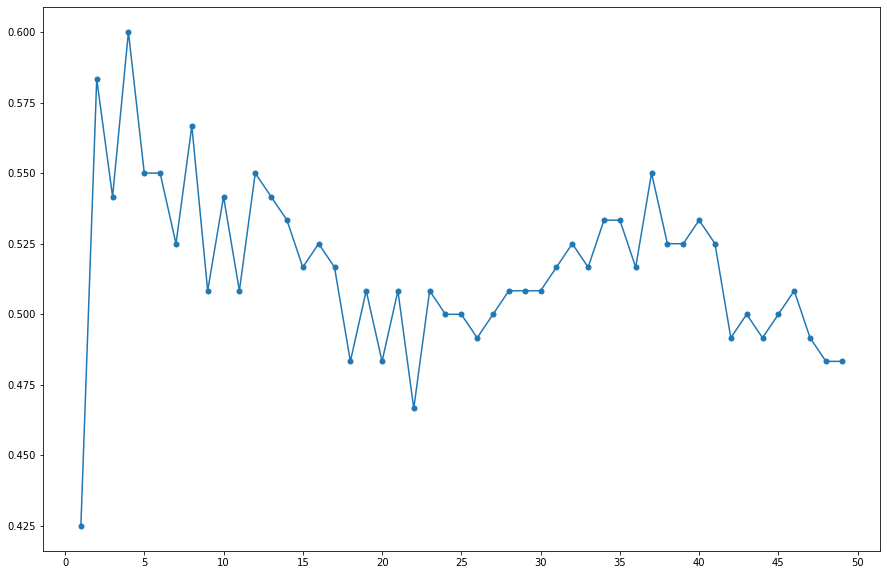

In [ ]:
x = np.random.randint(low=0, high=50, size=50)
plt.figure(figsize=(15,10))
plt.plot(range(1,50),error_rate, marker='o', markersize=5)
plt.xticks(np.arange(0, len(x)+1, 5))

--->Best K=**22:**

In [ ]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knn_best = neighbors.KNeighborsClassifier(n_neighbors = 22)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=22)

Save model

In [ ]:
import pickle
filename = 'knn_best.sav'
pickle.dump(knn_best, open(filename, 'wb'))

##Đánh giá

In [ ]:
cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.41


In [ ]:
cv_scores = cross_val_score(knn_best, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.39


In [ ]:
ypred = knn.predict(X_test)
ypred_best = knn_best.predict(X_test)

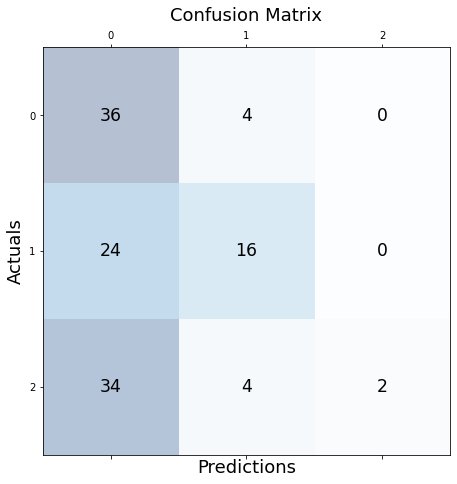

              precision    recall  f1-score   support

           0       0.38      0.90      0.54        40
           1       0.67      0.40      0.50        40
           2       1.00      0.05      0.10        40

    accuracy                           0.45       120
   macro avg       0.68      0.45      0.38       120
weighted avg       0.68      0.45      0.38       120



In [ ]:
cm = confusion_matrix(y_test, ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
cr = classification_report(y_test, ypred)
print(cr)

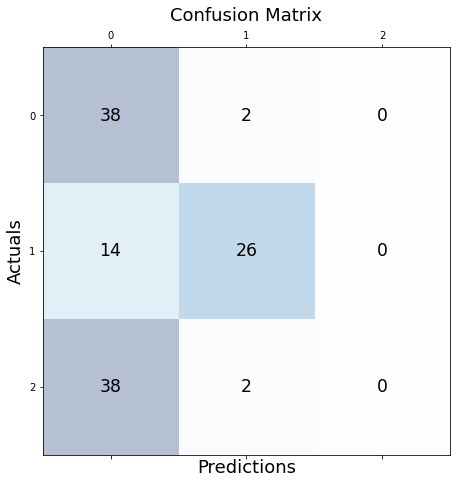

              precision    recall  f1-score   support

           0       0.42      0.95      0.58        40
           1       0.87      0.65      0.74        40
           2       0.00      0.00      0.00        40

    accuracy                           0.53       120
   macro avg       0.43      0.53      0.44       120
weighted avg       0.43      0.53      0.44       120



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test, ypred_best)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
cr = classification_report(y_test, ypred_best)
print(cr)

Load model

In [ ]:
best_knn = pickle.load(open(filename, 'rb'))